## MS Example 1: Multiplicative Noise

In [1]:
import numpy as np
import dfo_v1 as dfo
import ECNoise as ECN
import active_subspaces as ac
import matplotlib.pyplot as plt

We choose $\mathbf{x}^{(0)}=(100,0.1,u,u,\ldots,u)$, $u \sim U[-100,100]$.

We let $t: \mathbf{x}: \mathbb{R}^{10} \to \mathbb{R}$, where $t(\mathbf{x})=(x_1^2+x_2^2+x_3^2)(1+ k\epsilon)$, where $\epsilon \sim N(0,1)$ so that $k\epsilon \sim N(0,k^2)$ and $L_1=2$.

In [32]:
dim=10
xinit=np.transpose([200*np.random.rand(dim)])
print(np.shape(xinit))

#my nasty initial condition, but all others will plateau
#xinit[0]=100
#xinit[1]=.1
print(np.transpose(xinit))

(10, 1)
[[119.64020286  32.91321078  11.89237394  21.82102313  79.67766289
   99.40989714 172.19107826  83.80172983  46.77399673 153.26940547]]


In [33]:
k=1E-4
def tfun(x,var=k):
    y=np.copy(x)
    return np.dot(np.transpose(y[0:3,:]),y[0:3,:])*(1+(k**.5)*np.random.randn(1))
# Print check
print(tfun(xinit))

[[15620.8194349]]


In [34]:
M=15 # number of ECNoise f evals

noise_array=ECN.ECNoise(tfun,xinit,M,mult=True)
mynoise=noise_array[0][0]
gen_f_vals=noise_array[2]
print(gen_f_vals, mynoise)

(10, 1) (10, 1)
[15387.74147395 15447.78658365 15531.56907405 15504.13310079
 15446.55462165 15635.31739969 15385.50596818 15311.32190511
 15546.55516266 15589.22332821 15401.9583358  15779.15016783
 15588.10537827 15577.83435151 15637.01424665] 4.0624263388831364e-05


In [35]:
print('estimated noise var is', mynoise, 'true var is', k, 'with relative error', abs(mynoise-k)/k)

estimated noise var is 4.0624263388831364e-05 true var is 0.0001 with relative error 0.5937573661116864


In [36]:
h=1/M
fm=gen_f_vals[1]
f0=gen_f_vals[2]
fp=gen_f_vals[3]
L_1_hat=abs(fp-2*f0+fm)*(1/h)**2*(1/fm)

d1=abs(fp-f0)*(1/h)
d2=abs(fm-f0)*(1/h)
L_1_hat_1=abs(d1-d2)*(1/h)*(1/fm)


print('estimated upper bound on ||f''|| is', L_1_hat, 'estimated value of L_1 from FD is', L_1_hat_1)

estimated upper bound on ||f|| is 1.6199184387346484 estimated value of L_1 from FD is 0.8206979225695213


In [37]:
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,dim)
h=dfo.get_h(L_1_hat,dim)

In [38]:
x=np.copy(xinit)
maxit=500
xhist=np.array(x)
fhist=np.array(tfun(x))
yhist=xhist
ghist=fhist
L1Bhist=np.array(L_1_hat)
for i in range(maxit):
    [x,f,y,fy,p,q,L1B]=dfo.STARS(x,tfun,mu_star,h,mult=True)
    xhist=np.hstack((xhist,x))
    fhist=np.vstack((fhist,f))
    yhist=np.hstack((yhist,y))
    ghist=np.vstack((ghist,fy))
    L1Bhist=np.vstack((L1Bhist,L1B))

In [39]:
print('our algorithm terminates with x value',np.transpose(x), 'which has f value',f)

our algorithm terminates with x value [[ 1.64685039e-03 -6.36779162e-04 -6.41161993e-04  4.69356900e+01
   1.13037033e+02  7.36178834e+01  1.52880414e+02  8.29072175e+01
   4.71084927e+01  1.80562845e+02]] which has f value [[3.52035363e-06]]


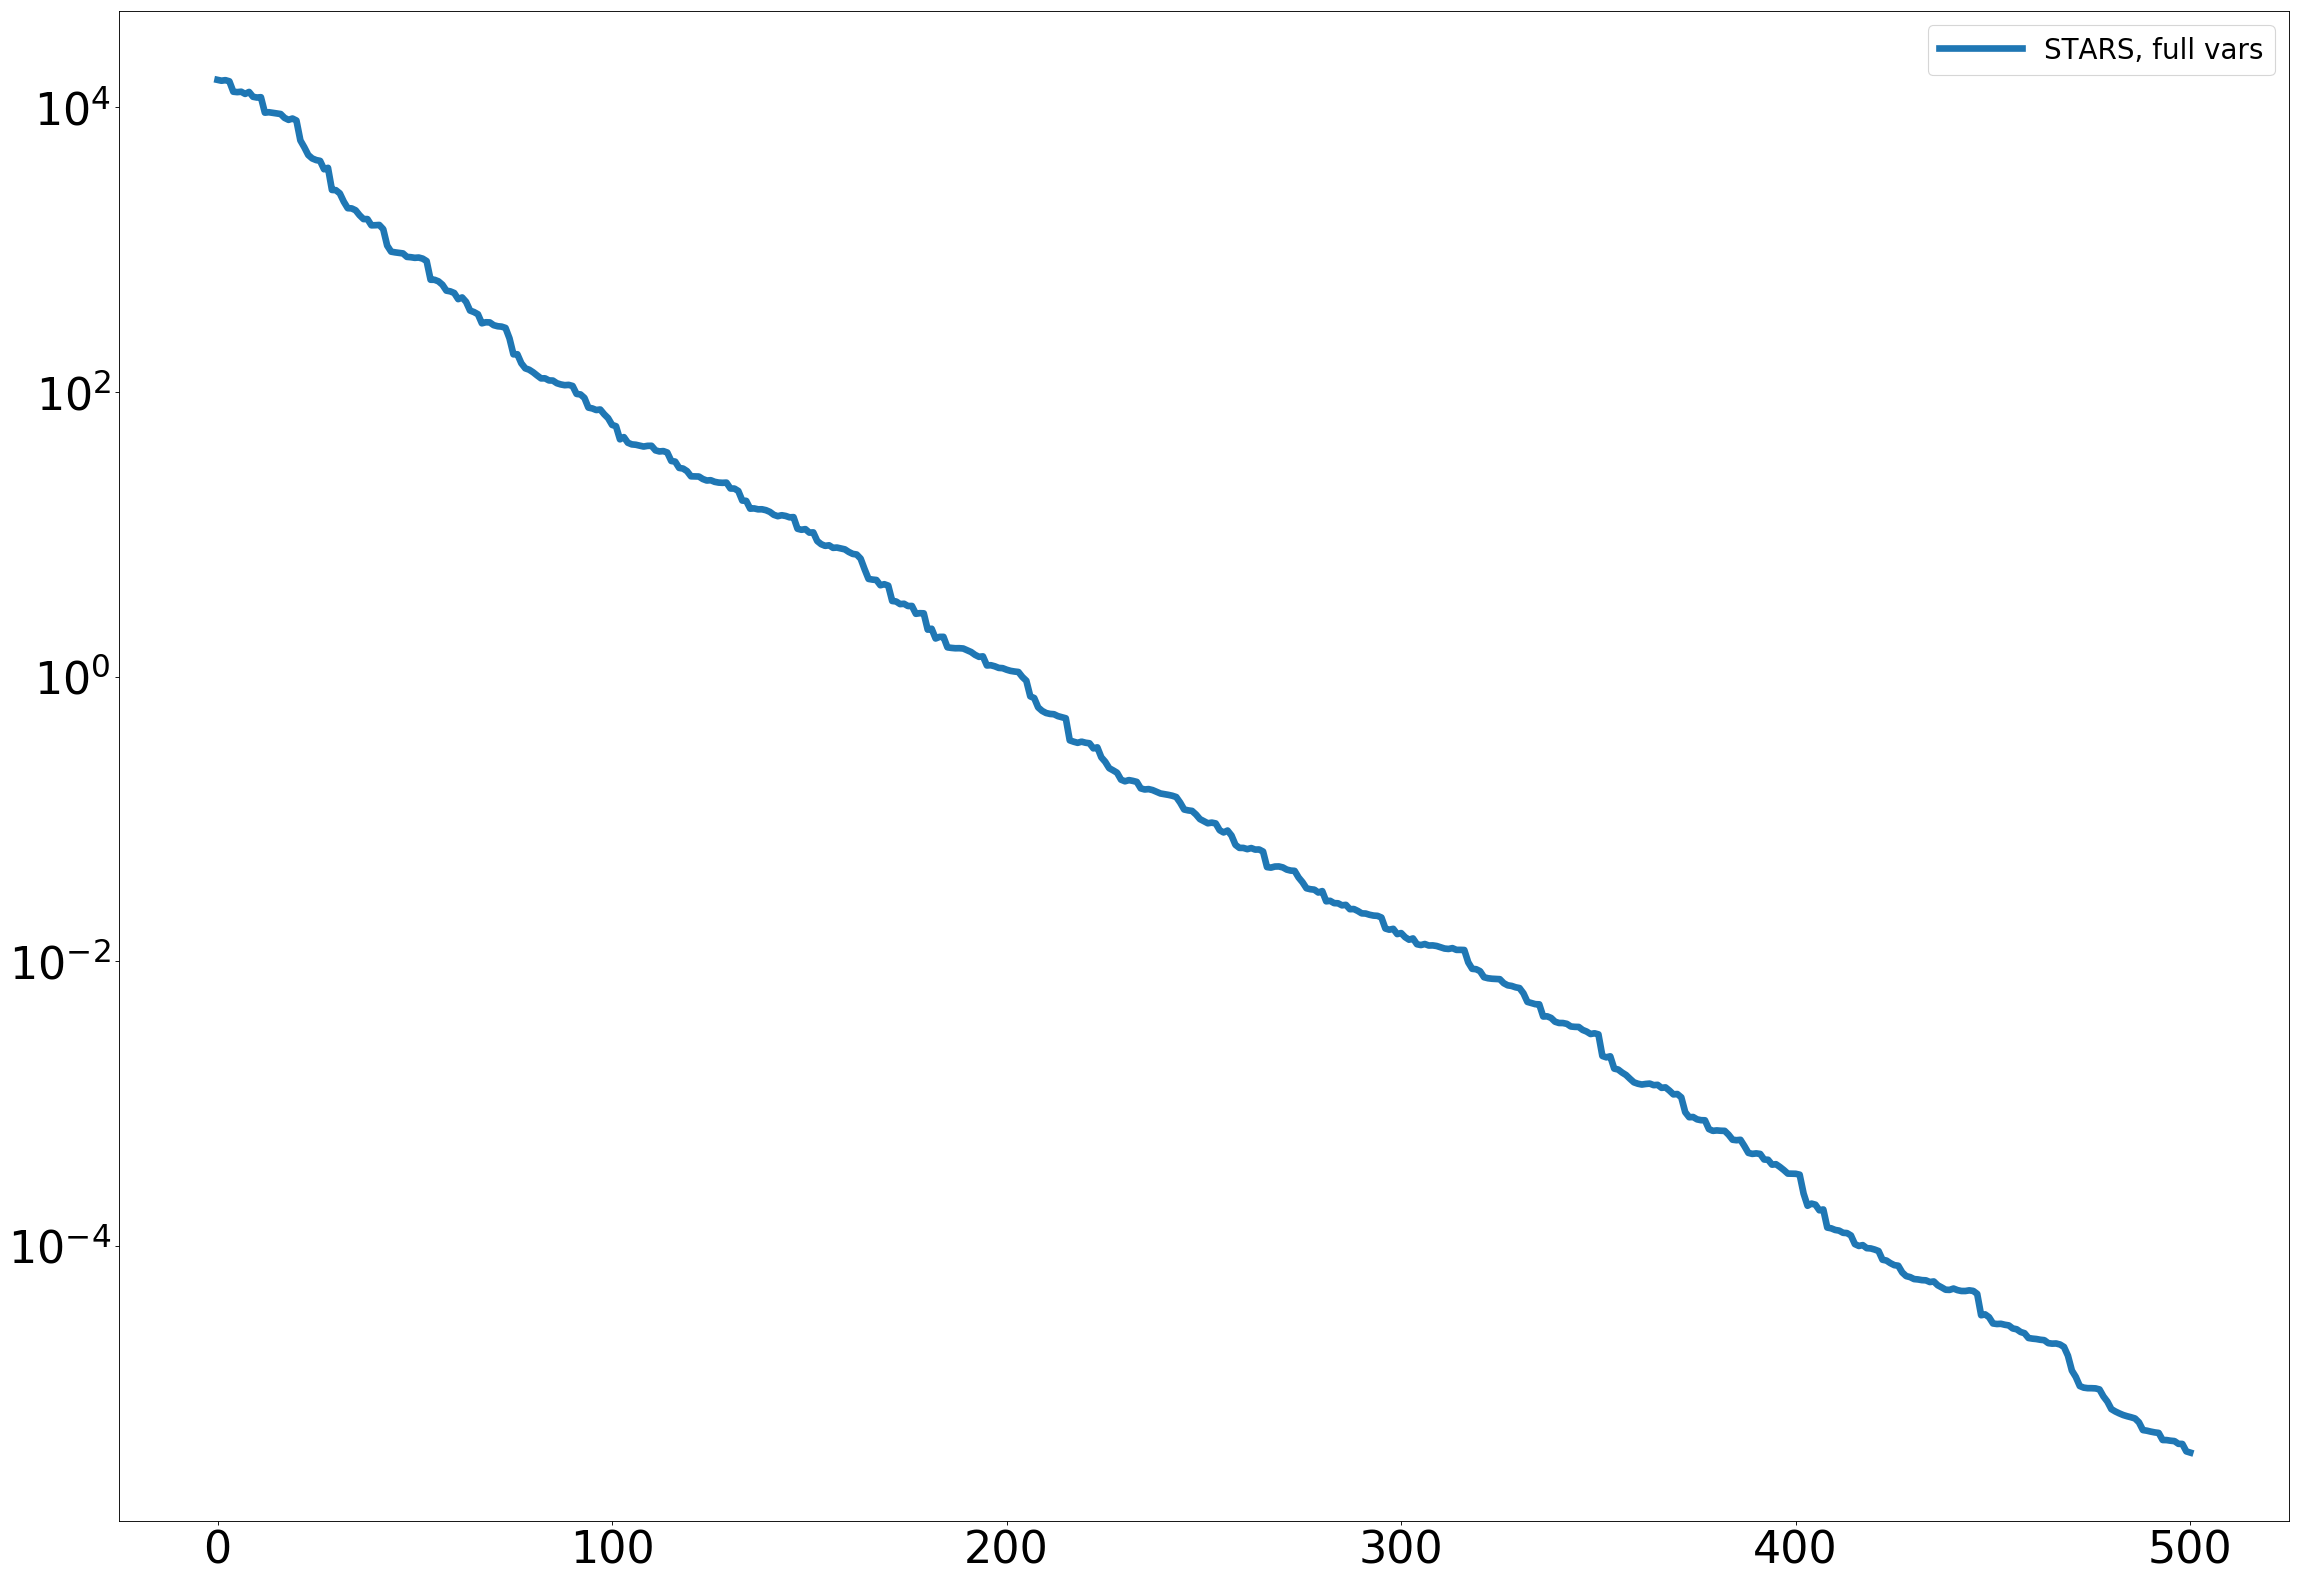

In [40]:
params = {'legend.fontsize': 25,
          'legend.handlelength': 3}
plt.rcParams["figure.figsize"] = (35,25)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 40
plt.rcParams['figure.titlesize'] = 'xx-large'
plt.rcParams.update(params)



plt.semilogy(fhist,lw=6,label='STARS, full vars')
plt.legend()
plt.show()

## Sing vals weights

n should be an integer. Performing conversion.
[[2.26215167e+04]
 [1.58786768e+02]
 [9.03657376e+01]
 [8.39824460e+01]
 [7.48661542e+01]
 [3.12936949e+01]
 [2.40433912e+01]
 [1.95216862e+01]
 [9.56142280e+00]
 [5.84025565e-01]]
n should be an integer. Performing conversion.
[[5.47662456e+03]
 [4.86515540e+01]
 [3.91796124e+01]
 [2.64916230e+01]
 [1.54290184e+01]
 [1.13873184e+01]
 [6.82377460e+00]
 [2.07729990e+00]
 [1.66773528e+00]
 [4.78398038e-01]]
n should be an integer. Performing conversion.
[[5.37096489e+03]
 [4.61613010e+01]
 [3.36303543e+01]
 [2.57218620e+01]
 [1.50609045e+01]
 [1.10281173e+01]
 [4.97577210e+00]
 [2.45421598e+00]
 [1.47383522e+00]
 [9.51331382e-01]]


C:\Users\Owner\Dropbox\repos\personalresearch\Notebooks\dfo_v1.py:92: RuntimeWarning: invalid value encountered in subtract
  s = ((g - f0)/mu_star)*u
C:\Users\Owner\Dropbox\repos\personalresearch\Notebooks\dfo_v1.py:110: RuntimeWarning: invalid value encountered in subtract
  d1 = (f0-g)*(1/mu_star)
C:\Users\Owner\Anaconda3\lib\site-packages\numpy\ma\core.py:6649: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


n should be an integer. Performing conversion.
[[5.38421591e+03]
 [4.45143734e+01]
 [3.20574617e+01]
 [2.76837621e+01]
 [1.51336292e+01]
 [1.11902826e+01]
 [4.57096995e+00]
 [2.51905344e+00]
 [1.51301895e+00]
 [1.25209442e+00]]
n should be an integer. Performing conversion.
[[5.35077372e+03]
 [4.38665331e+01]
 [3.20195482e+01]
 [2.73597859e+01]
 [1.51363914e+01]
 [1.10684711e+01]
 [4.26973606e+00]
 [2.52211813e+00]
 [1.53730598e+00]
 [1.19694894e+00]]
n should be an integer. Performing conversion.
[[5.34186182e+03]
 [4.37700296e+01]
 [3.21299762e+01]
 [2.72646697e+01]
 [1.51451534e+01]
 [1.11215579e+01]
 [4.28746253e+00]
 [2.49059427e+00]
 [1.53909693e+00]
 [1.16902711e+00]]


C:\Users\Owner\Dropbox\repos\personalresearch\Notebooks\dfo_v1.py:112: RuntimeWarning: overflow encountered in multiply
  d2 = (g-f1)*(1/h)
C:\Users\Owner\Dropbox\repos\personalresearch\Notebooks\dfo_v1.py:112: RuntimeWarning: invalid value encountered in subtract
  d2 = (g-f1)*(1/h)
C:\Users\Owner\Dropbox\repos\personalresearch\Notebooks\dfo_v1.py:80: RuntimeWarning: invalid value encountered in add
  y = x_init + (mu_star)*u


n should be an integer. Performing conversion.
[[5.34285728e+03]
 [4.37304708e+01]
 [3.22076951e+01]
 [2.73429662e+01]
 [1.51365641e+01]
 [1.11076569e+01]
 [4.31170870e+00]
 [2.45770054e+00]
 [1.53393538e+00]
 [1.16252920e+00]]
n should be an integer. Performing conversion.
[[5.34351839e+03]
 [4.36864044e+01]
 [3.22630182e+01]
 [2.74229206e+01]
 [1.51311894e+01]
 [1.10916421e+01]
 [4.31501444e+00]
 [2.43744309e+00]
 [1.52972634e+00]
 [1.16151725e+00]]
n should be an integer. Performing conversion.
[[5.34353303e+03]
 [4.36860215e+01]
 [3.22633165e+01]
 [2.74234778e+01]
 [1.51311158e+01]
 [1.10914501e+01]
 [4.31511071e+00]
 [2.43728489e+00]
 [1.52969902e+00]
 [1.16156545e+00]]


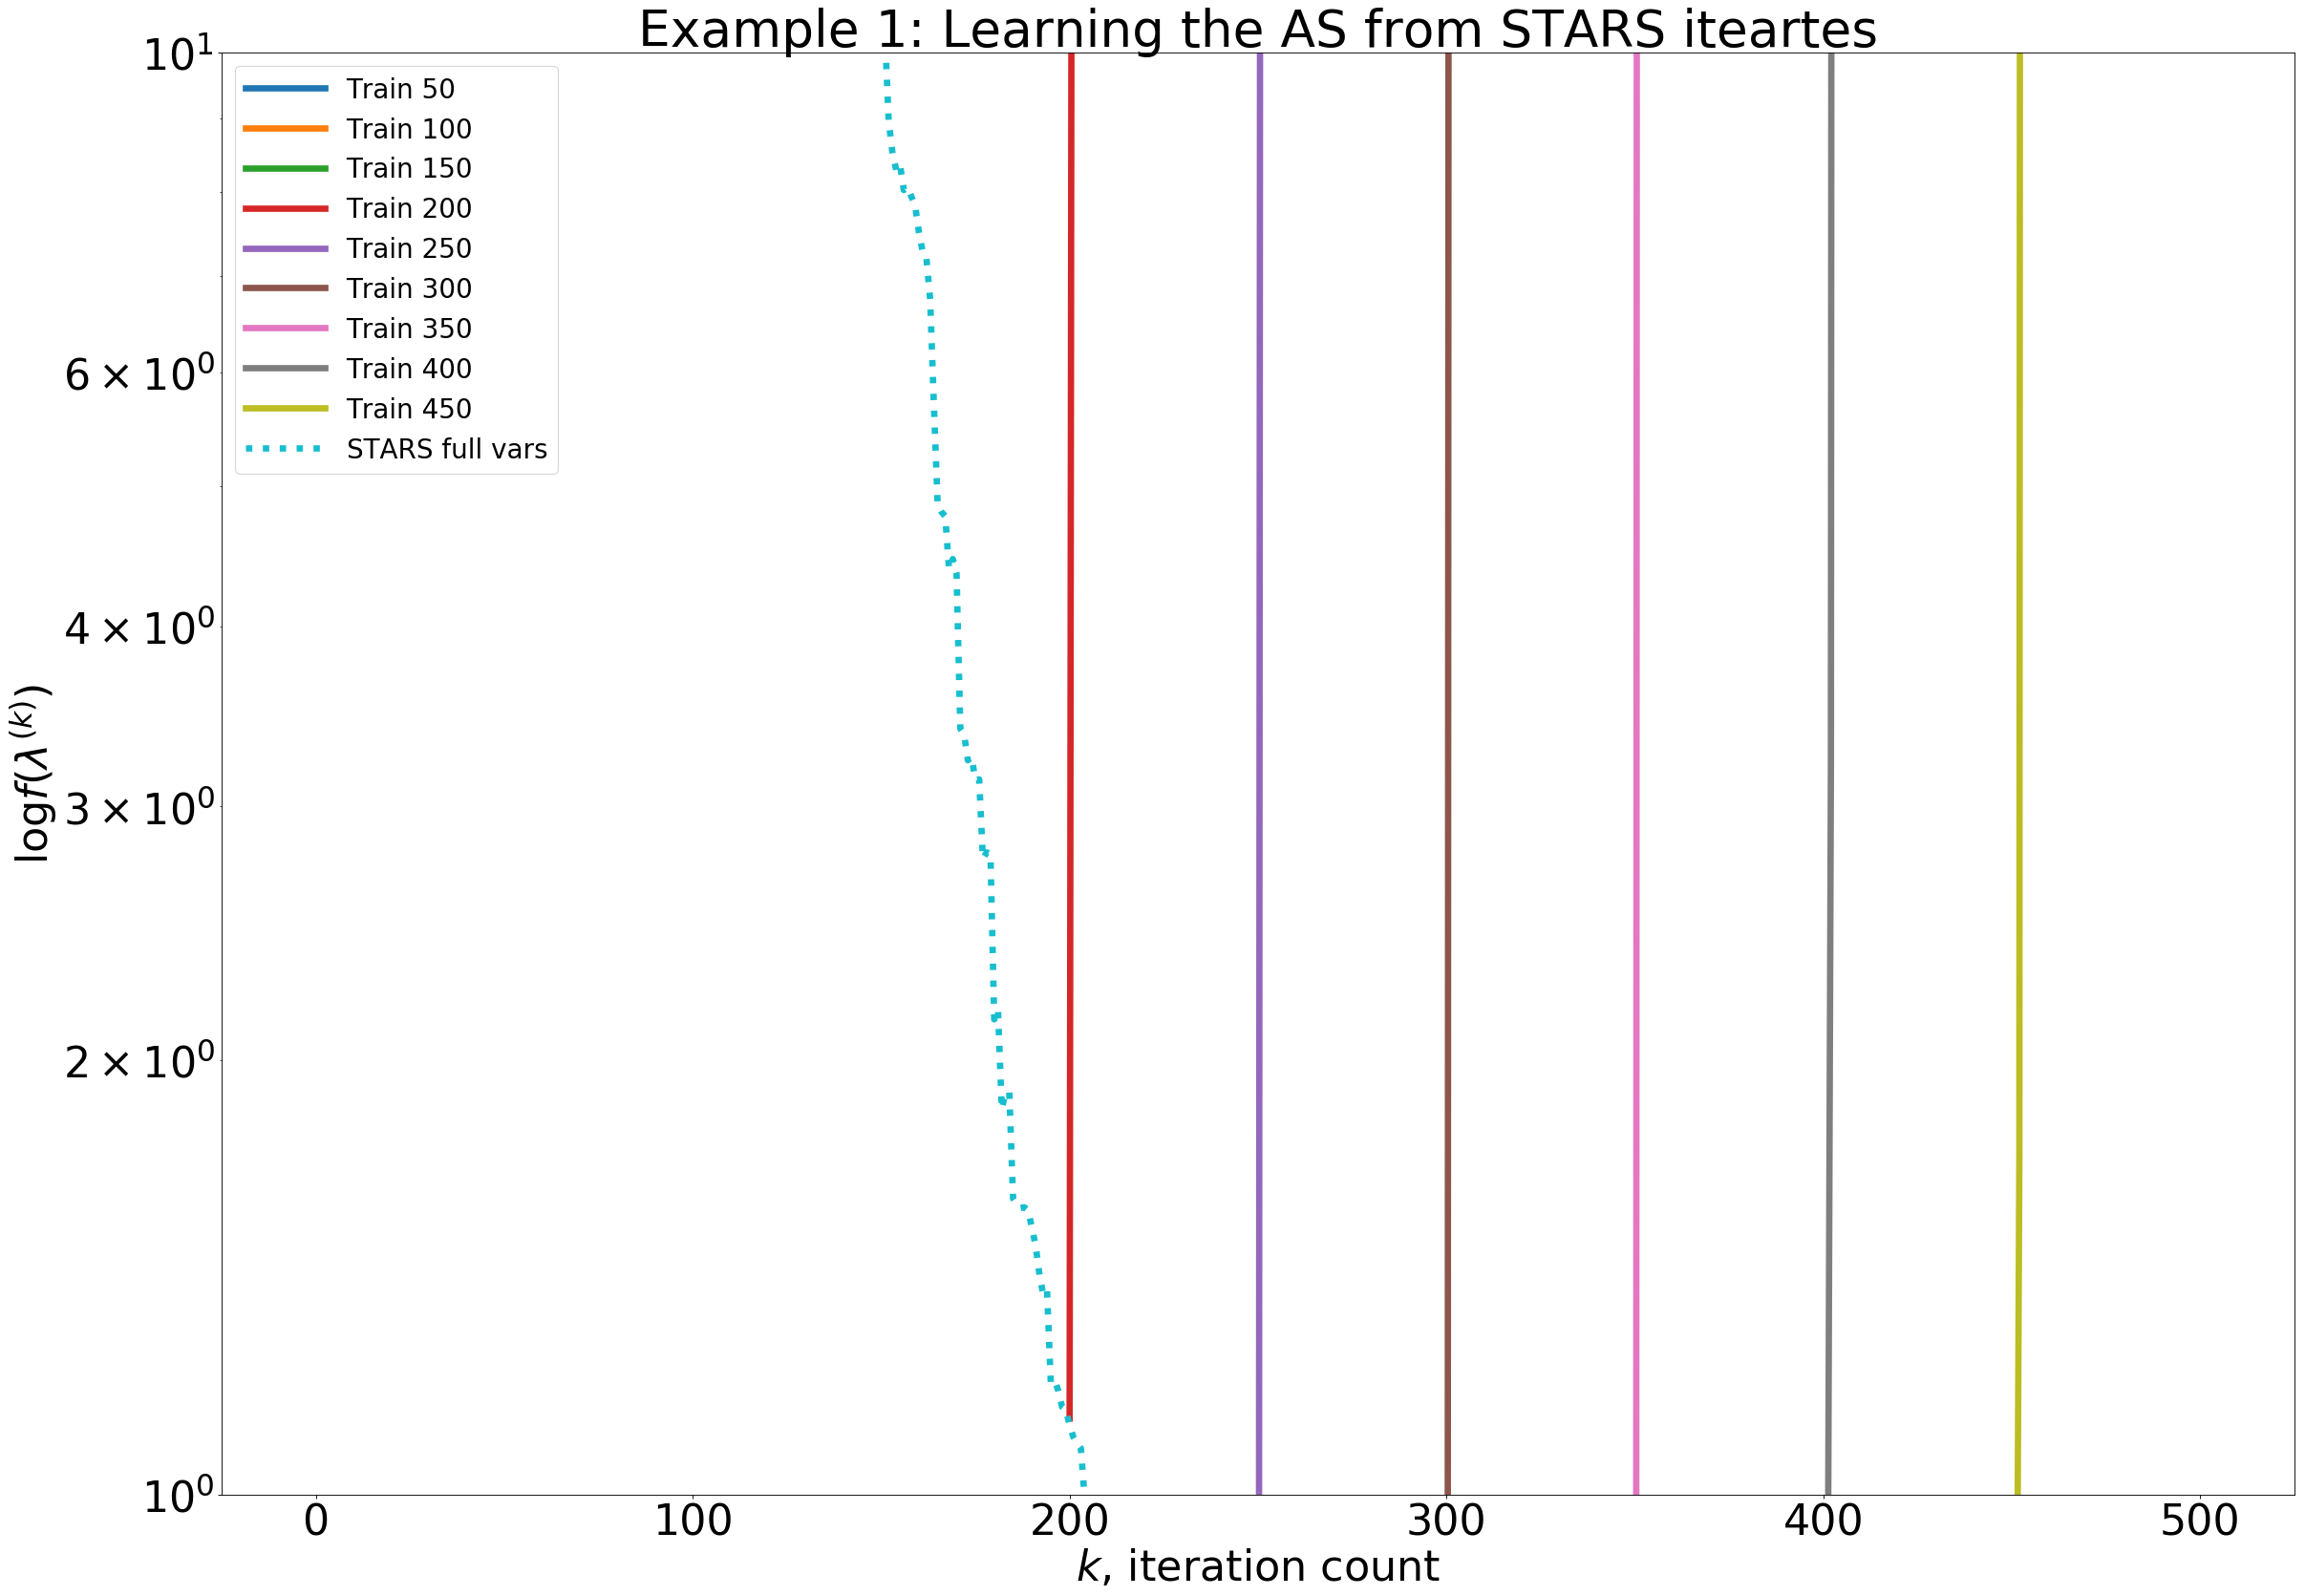

In [43]:
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

for tr_stop in range(50,500,50):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    sub=ss.eigenvecs[:,0:3]
    

    our_wts=np.sqrt(ss.eigenvals)
    print(our_wts)
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))


    for i in range(0,500-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub, wts=our_wts, mult=True)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,501),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

## Equal weights

n should be an integer. Performing conversion.
[[9.86978806e+03]
 [4.04250035e+01]
 [2.11317887e+01]
 [1.98021730e+01]
 [1.31362610e+01]
 [1.00716492e+01]
 [9.01481604e+00]
 [8.27339028e+00]
 [1.71646232e+00]
 [1.13452041e+00]]
n should be an integer. Performing conversion.
[[2.07076592e+03]
 [1.77552928e+01]
 [7.14041284e+00]
 [5.80029676e+00]
 [5.13159823e+00]
 [4.80226570e+00]
 [3.05432012e+00]
 [1.90463370e+00]
 [7.95472697e-01]
 [1.34719612e-01]]
n should be an integer. Performing conversion.
[[1.58799830e+03]
 [9.62298838e+00]
 [7.75418019e+00]
 [6.05324778e+00]
 [5.24078650e+00]
 [3.89981054e+00]
 [2.41355881e+00]
 [1.94433927e+00]
 [9.76259428e-01]
 [5.85705213e-01]]
n should be an integer. Performing conversion.
[[1.37942500e+03]
 [9.01268226e+00]
 [7.53387042e+00]
 [5.75734805e+00]
 [4.59204877e+00]
 [3.60770902e+00]
 [2.31133014e+00]
 [1.93306907e+00]
 [8.48838346e-01]
 [5.44845717e-01]]
n should be an integer. Performing conversion.
[[1.13664110e+03]
 [8.25551599e+00]
 [7.1

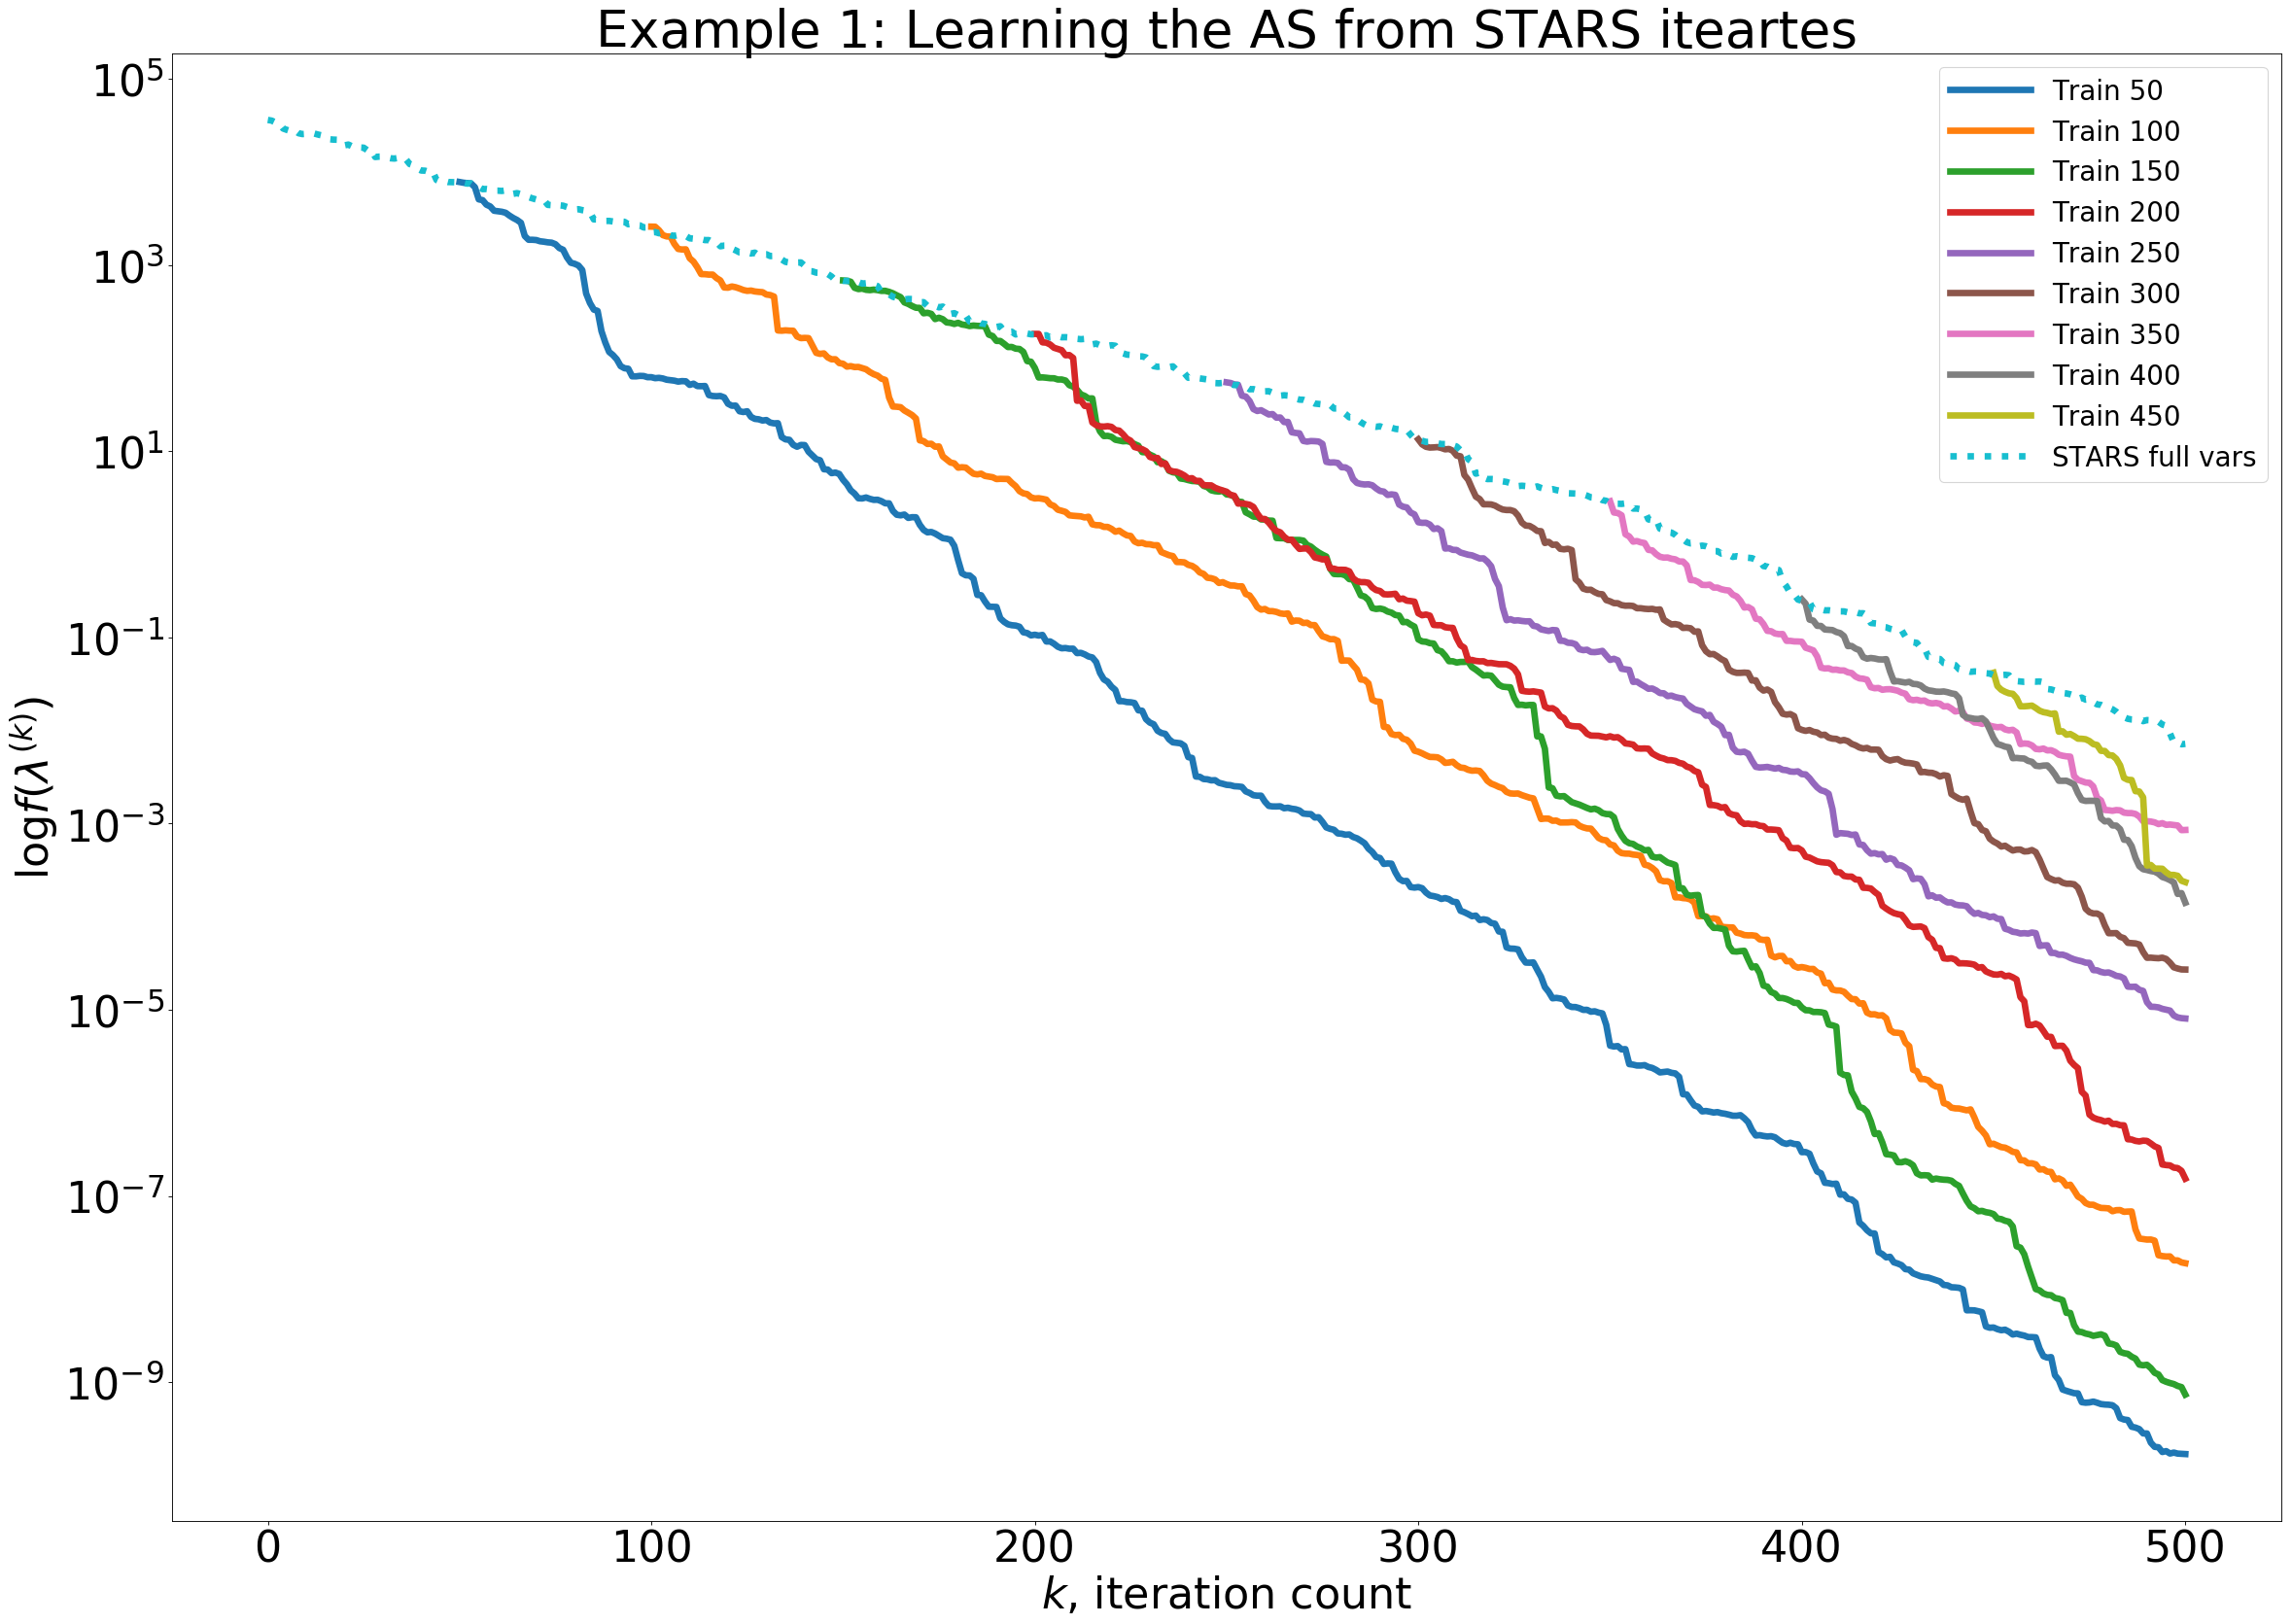

In [19]:
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

for tr_stop in range(50,500,50):

    trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
    trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
    trainx=np.transpose(trainx)


    # Use Local Linears
    #df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    #ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

    #sub=ss.eigenvecs[:,0:3]
    sub=ss.eigenvecs
    
    our_wts=np.sqrt(ss.eigenvals)
    print(our_wts)
    
    x4=np.transpose([xhist[:,tr_stop-1]])
    xhist4=np.array(x4)
    fhist4=np.array(tfun(x4))


    for i in range(0,500-tr_stop):
        [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub, wts=None, mult=True)
        xhist4=np.hstack((xhist4,x4))
        fhist4=np.vstack((fhist4,f))
    plt.semilogy(range(tr_stop,501),fhist4,label='Train '+str(tr_stop),lw=6)


plt.semilogy(fhist, ls=':', lw=6, label='STARS full vars')

plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: Learning the AS from STARS iteartes')
plt.legend()
plt.show()

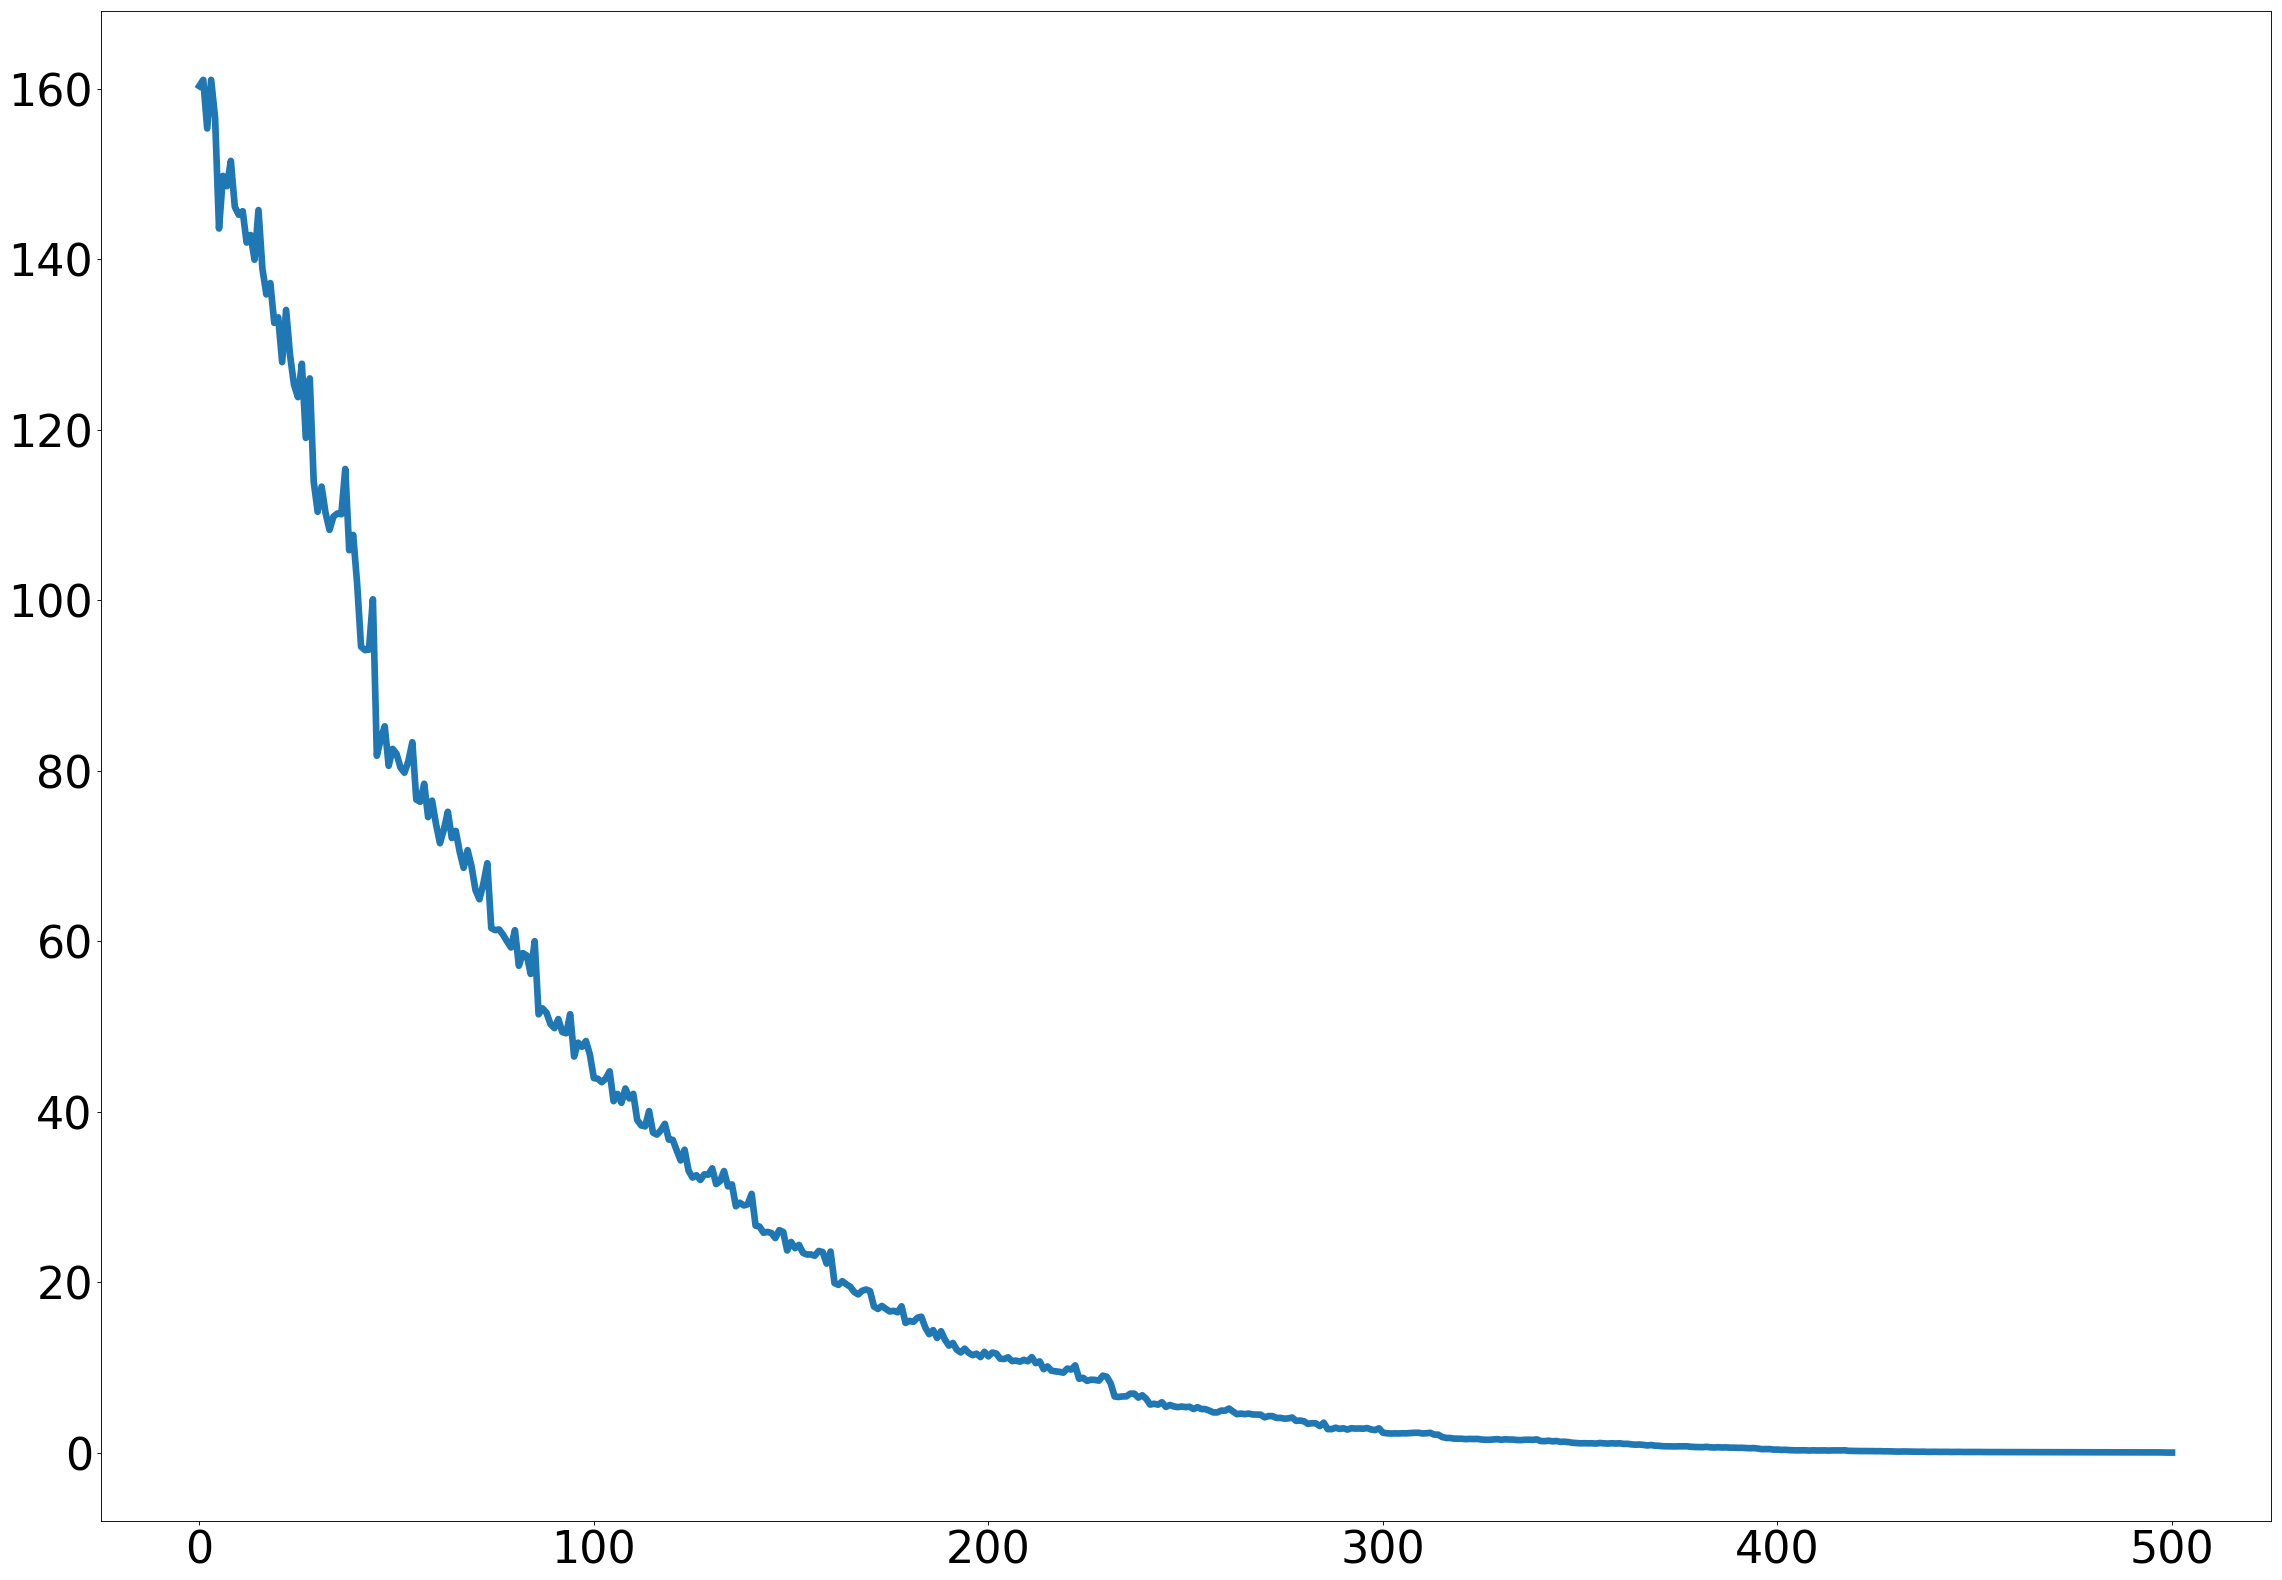

In [31]:
plt.plot(yhist[2],lw=6)

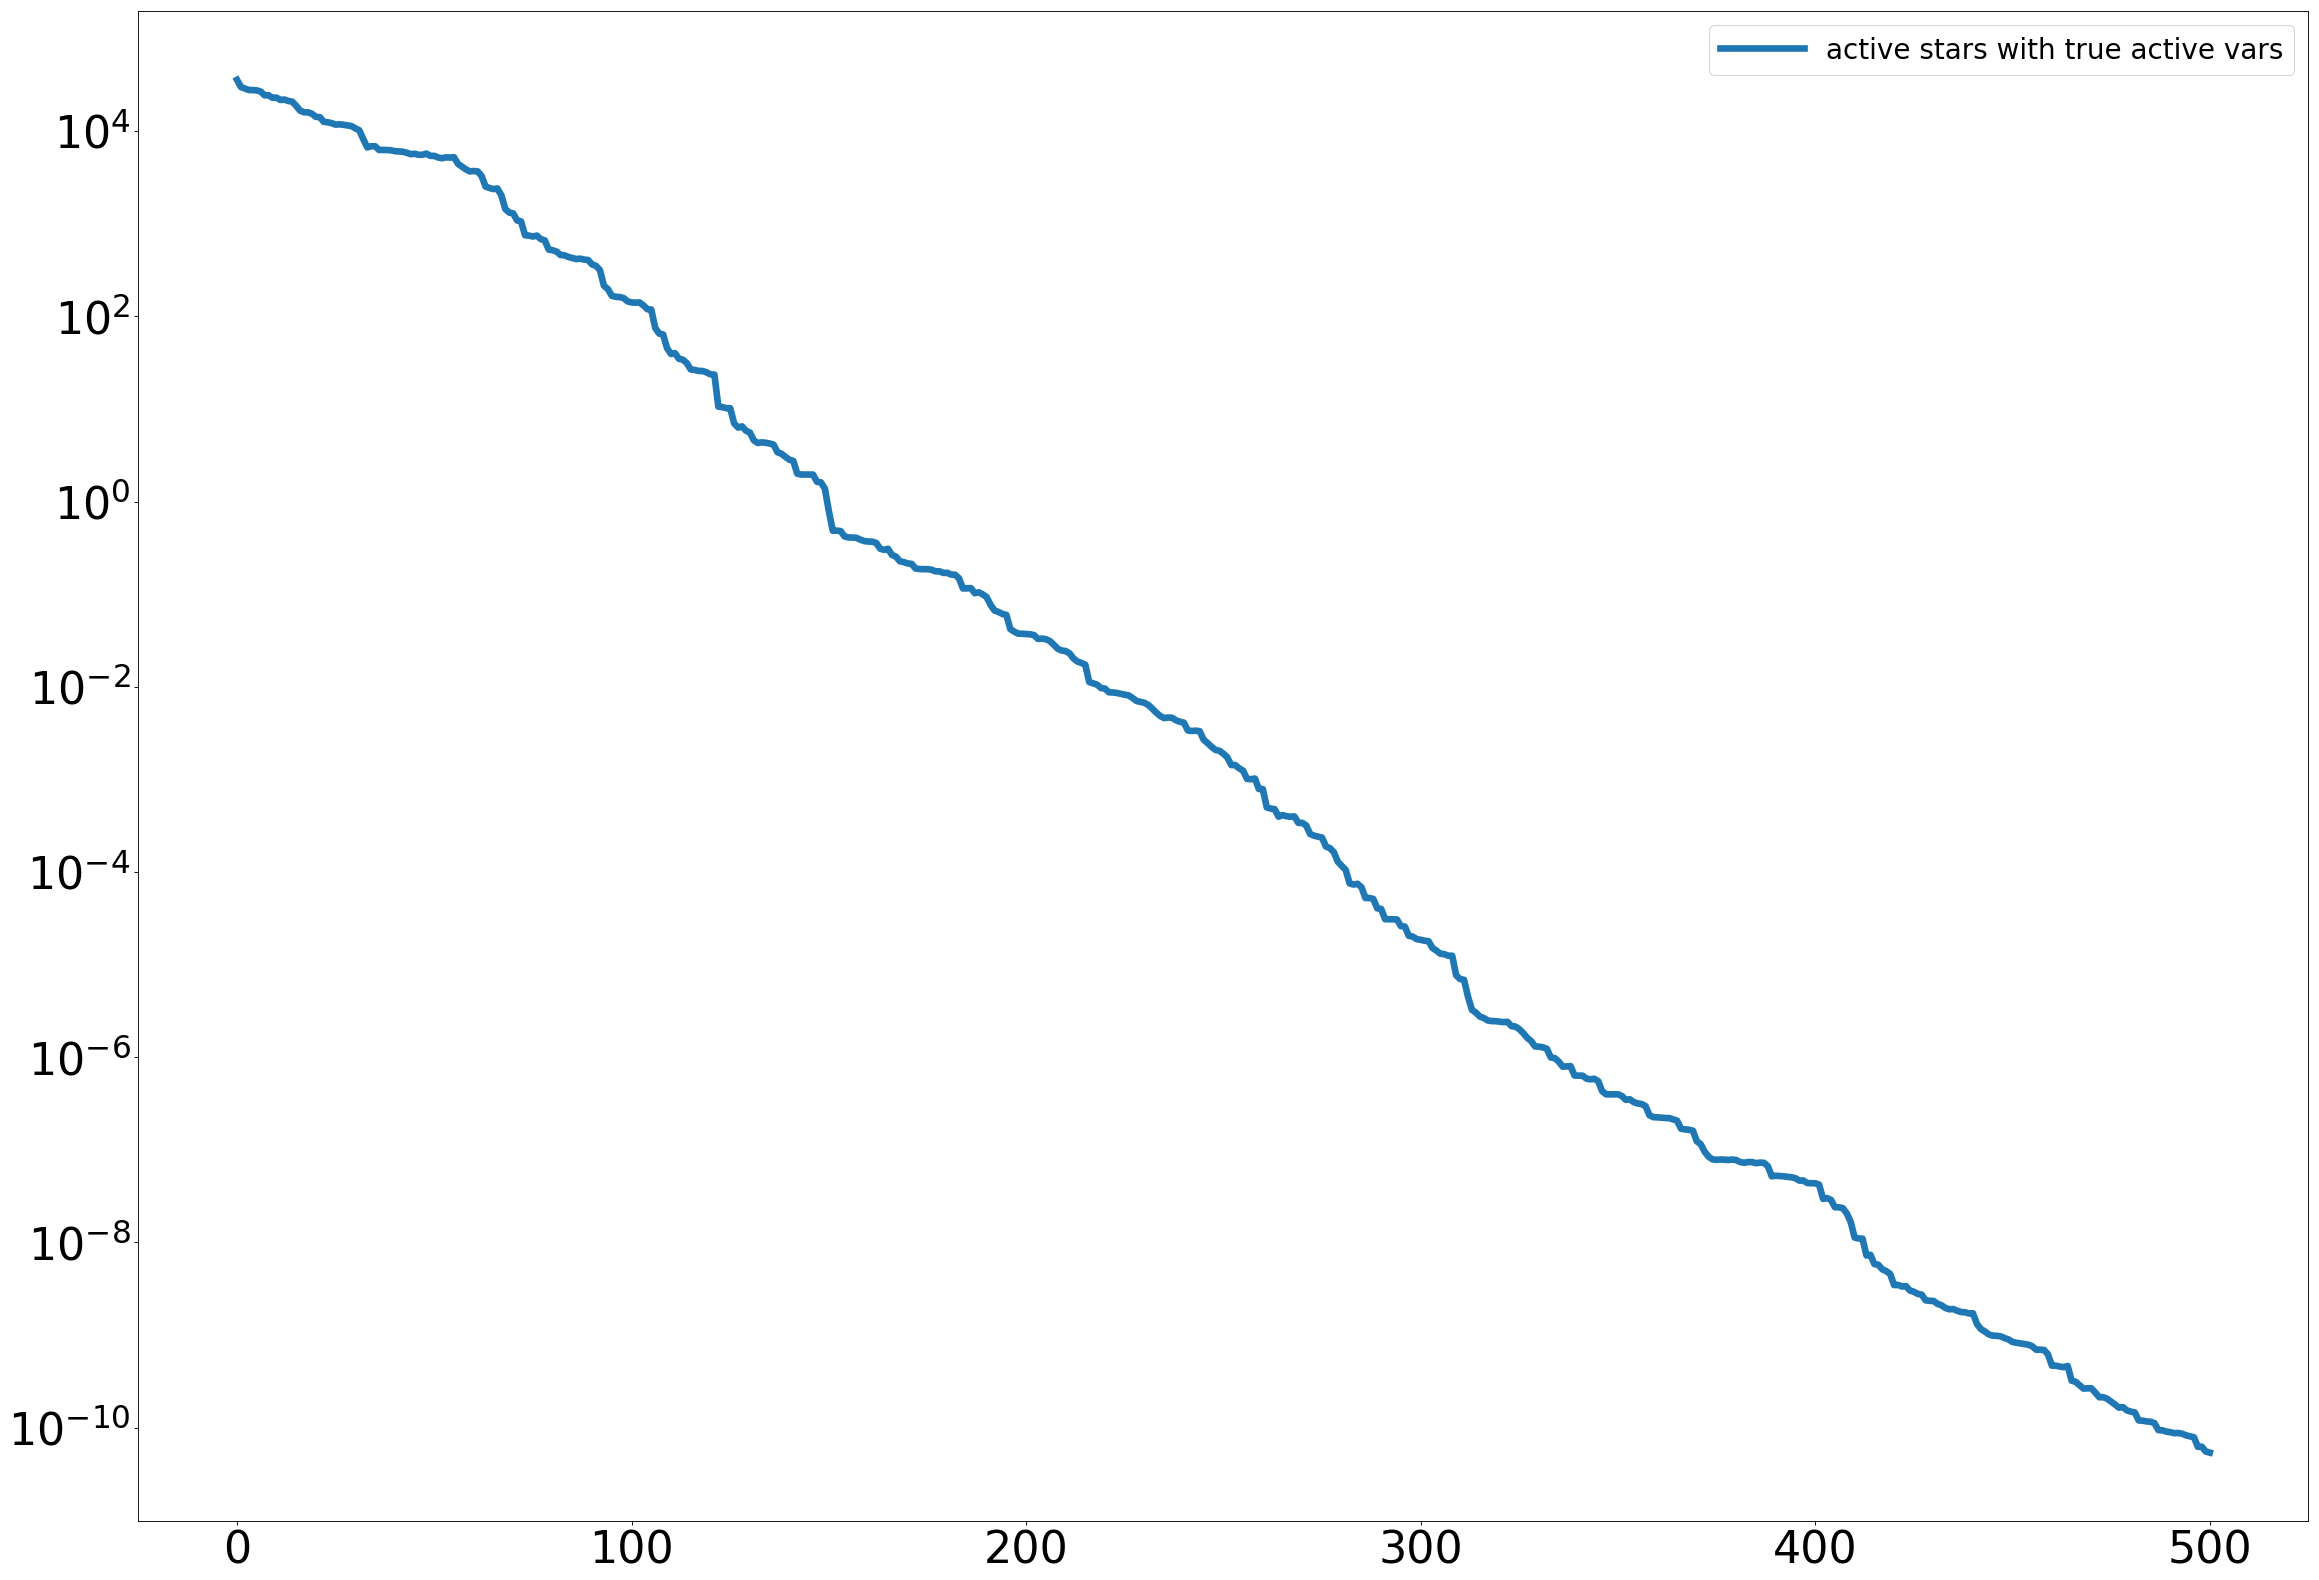

In [13]:
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)


x3=np.copy(xinit)
xhist3=np.array(x3)
fhist3=np.array(tfun(x3))
active=np.eye(dim)
active=np.transpose(active[0:3,:])
eigenvals=np.zeros((dim,1))
for i in range(3):
    eigenvals[i]=1


for i in range(500):
    [x3,f,temp1,temp2, p ,q,L1B]=dfo.STARS(x3,tfun,mu_star,h,active=active,mult=True,wts=eigenvals)
    xhist3=np.hstack((xhist3,x3))
    fhist3=np.vstack((fhist3,f))
    
plt.semilogy(fhist3,lw=6, label='active stars with true active vars')
plt.legend()
plt.show()

n should be an integer. Performing conversion.
[[2.07076592e+03]
 [1.77552928e+01]
 [7.14041284e+00]
 [5.80029676e+00]
 [5.13159823e+00]
 [4.80226570e+00]
 [3.05432012e+00]
 [1.90463370e+00]
 [7.95472697e-01]
 [1.34719612e-01]]


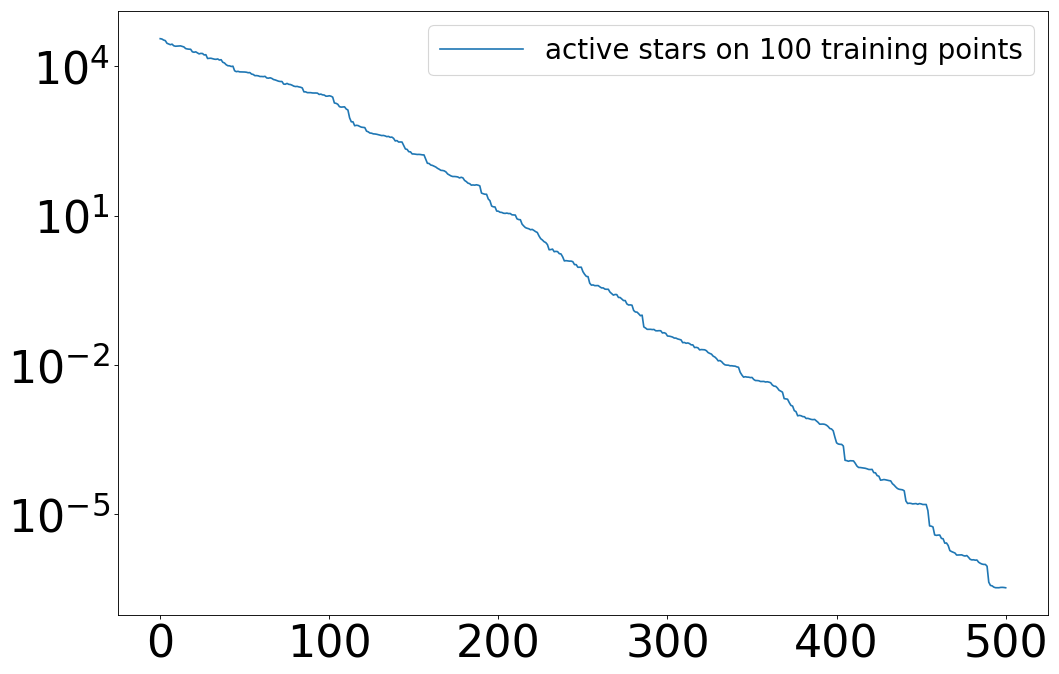

In [14]:
plt.figure(figsize=(15,10))
ss = ac.subspaces.Subspaces()
mu_star=dfo.get_mult_mu_star(mynoise,L_1_hat,3)
h=dfo.get_h(L_1_hat,3)

tr_stop=100

trainx=np.hstack((xhist[:,0:tr_stop],yhist[:,0:tr_stop]))
trainf=np.vstack((fhist[0:tr_stop],ghist[0:tr_stop]))
trainx=np.transpose(trainx)



# Use Global Quadratic
ss.compute(X=trainx, f=trainf, nboot=0, sstype='QPHD')

sub=ss.eigenvecs
our_wts=np.sqrt(ss.eigenvals)
print(our_wts)
 
x4=np.transpose([xhist[:,tr_stop-1]])
xhist4=np.array(x4)
fhist5=np.vstack((fhist[0:tr_stop],tfun(x4)))


for i in range(0,500-tr_stop):
    [x4,f,temp,temp2,p,q,L1B]=dfo.STARS(x4,tfun,mu_star,h,active=sub,wts=None, mult=True)
    xhist4=np.hstack((xhist4,x4))
    fhist5=np.vstack((fhist5,f))
    #plt.semilogy(range(tr_stop,301),fhist4,label='Train '+str(tr_stop))


plt.semilogy(fhist5, label='active stars on 100 training points')
plt.legend()
plt.show()

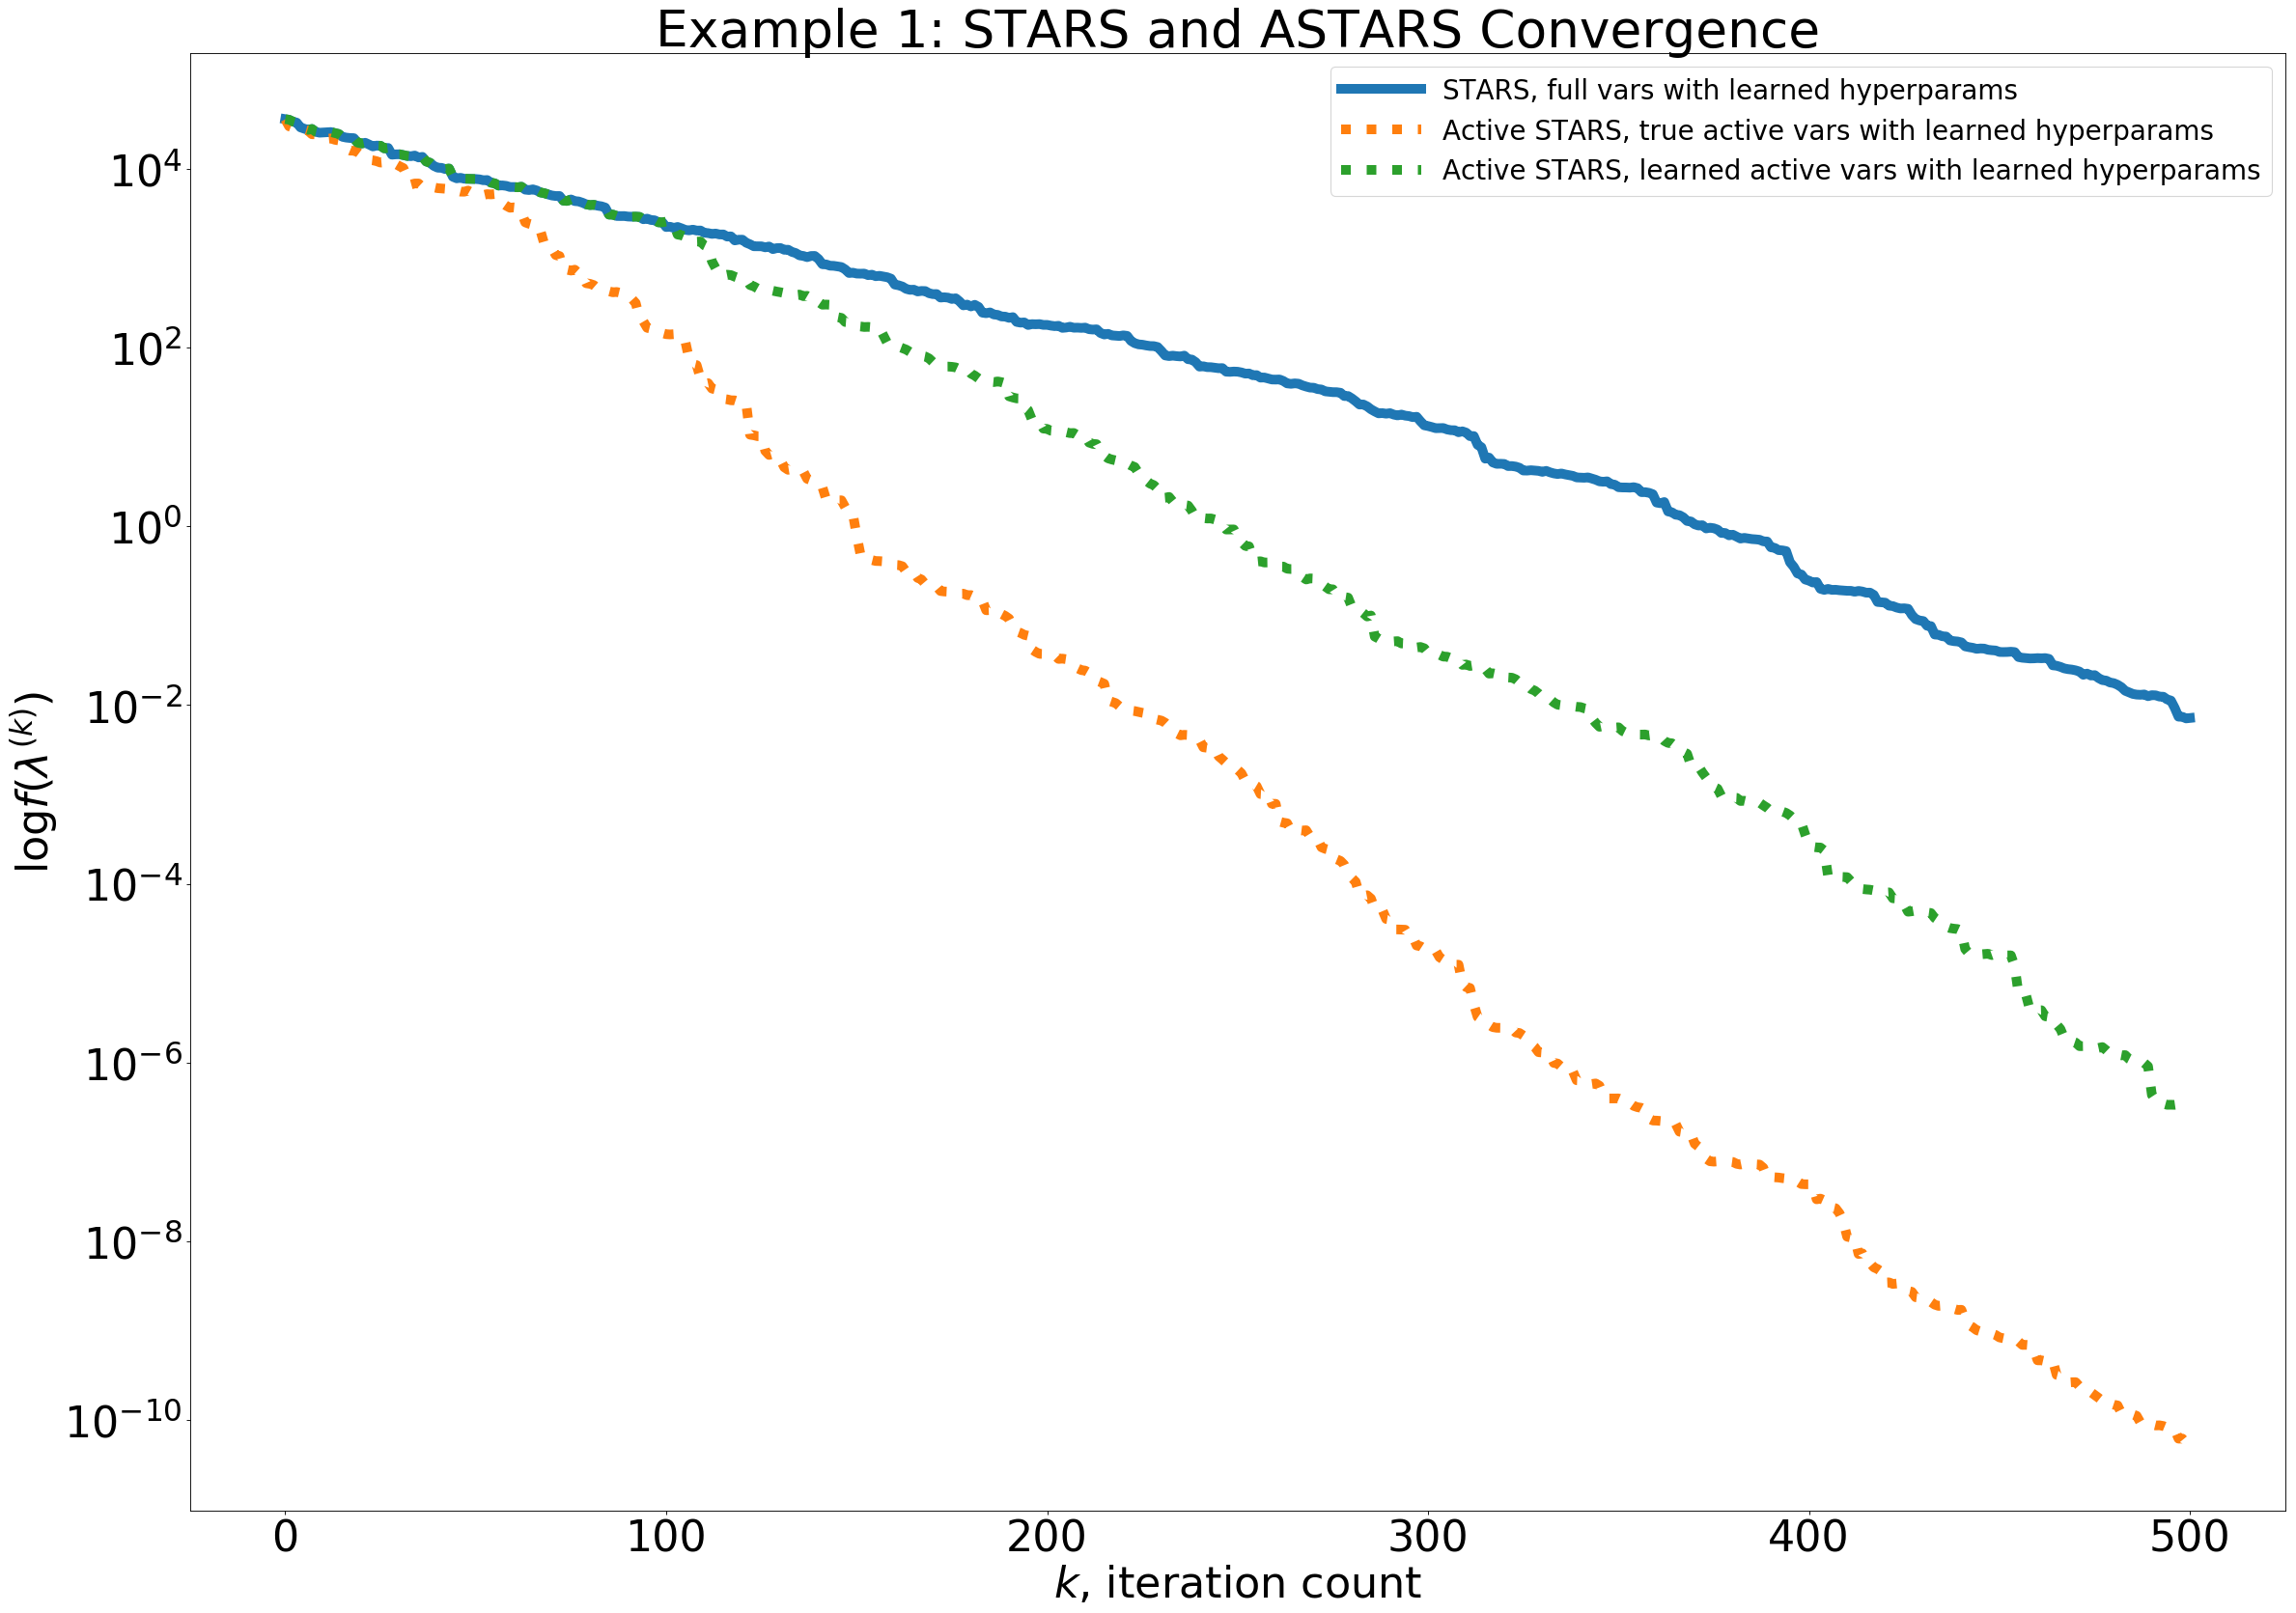

In [15]:
plt.xlabel('$k$, iteration count')
plt.ylabel('$\log f(\lambda^{(k)})$')
plt.title('Example 1: STARS and ASTARS Convergence')

plt.semilogy(fhist, lw=9, label='STARS, full vars with learned hyperparams')
plt.semilogy(fhist3, lw=9, ls=':',  label='Active STARS, true active vars with learned hyperparams')
plt.semilogy(fhist5, lw=9, ls=':',label='Active STARS, learned active vars with learned hyperparams')

plt.legend()
plt.show()